In [ ]:
import torch
from torch import nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
    print(f"{image_path} directory already exists.. so skipping download")
else:
    print(f"{image_path} directory does not exist, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading zip file...")
    f.write(request.content)

with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Extracting zip file...")
    zip_ref.extractall(image_path)

data/pizza_steak_sushi directory already exists.. so skipping download
Extracting zip file...


In [ ]:
import os
def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [ ]:
train_dir = image_path / "train"
test_dir = image_path / "test"

In [ ]:
import random
from PIL import Image

random.seed(42)

image_path_list = list(image_path.glob("*/*/*.jpg"))

random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

img=Image.open(random_image_path)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

img_as_array = np.asarray(img)

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [ ]:
data_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

data_transform(img).shape

torch.Size([3, 64, 64])

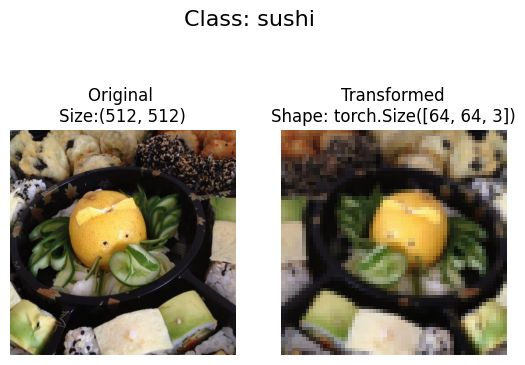

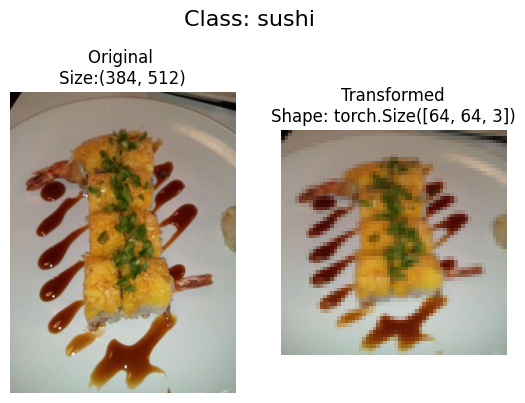

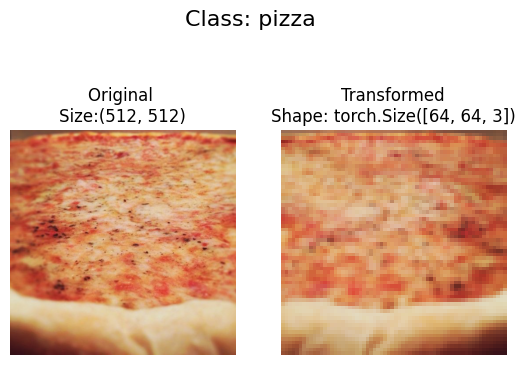

In [ ]:
def plot_transformed_images(image_paths:list, transform, n=3, seed=None):

  if seed:
    random.seed(seed)
  random_image_paths =  random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1,ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original \nSize:{f.size}")
      ax[0].axis(False)

      transformed_image = transform(f).permute(1,2,0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}",fontsize=16)

plot_transformed_images(image_paths = image_path_list,
                          transform= data_transform,
                          n=3,
                          seed=42)


In [ ]:
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform= data_transform,
                                  target_transform=None)
test_data = datasets.ImageFolder(root = test_dir,transform=data_transform)


In [ ]:
from torch.utils.data import DataLoader
BATCH_SIZE=1
train_dataloader= DataLoader(dataset=train_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False)




In [ ]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple,Dict, List


In [ ]:
target_directory = train_dir

class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])

class_names_found

['pizza', 'steak', 'sushi']

In [ ]:
def find_classes(directory:str) -> Tuple[list[str] , Dict[str,int]]:
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
  if not classes:
    raise FileNotFoundError(f"couldn't find any classes in {directory} ... please check folder")

  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
  return classes,class_to_idx

In [ ]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [ ]:
# Write a custom dataset class (inherits from torch.utils.data.Dataset)
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):

    # 2. Initialize with a targ_dir and transform (optional) parameter
    def __init__(self, targ_dir: str, transform=None) -> None:

        # 3. Create class attributes
        # Get all image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg")) # note: you'd have to update this if you've got .png's or .jpeg's
        # Setup transforms
        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # 4. Make function to load images
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path)

    # 5. Overwrite the __len__() method (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)

    # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        class_name  = self.paths[index].parent.name # expects path in data_folder/class_name/image.jpeg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label (X, y)
        else:
            return img, class_idx # return data, label (X, y)

In [ ]:
from torchvision import transforms
train_transforms = transforms.Compose([transforms.Resize(size=(64,64)),
                                       transforms.RandomHorizontalFlip(p=0.5),
                                       transforms.ToTensor()
                                       ])

test_transforms=transforms.Compose([transforms.Resize(size=(64,64)),
                                    transforms.ToTensor()
                                    ]
                                   )


In [ ]:
train_data_custom = ImageFolderCustom(targ_dir = train_dir,
                                    transform = train_transforms)
test_data_custom = ImageFolderCustom(targ_dir = test_dir,
                                     transform = test_transforms)

In [ ]:
# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):

    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)


For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.


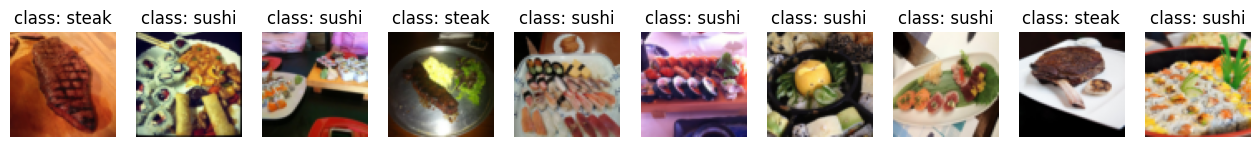

In [ ]:
display_random_images(train_data_custom,
                      n=20,
                      classes=class_names_found,
                      seed=42)

In [ ]:
BATCH_SIZE=32
NUM_WORKERS=0
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                    batch_size=BATCH_SIZE,
                                    num_workers = NUM_WORKERS,
                                    shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=BATCH_SIZE,
                                    num_workers = NUM_WORKERS,
                                    shuffle=False)

img_custom,label_custom = next(iter(train_dataloader_custom))

img_custom.shape

torch.Size([32, 3, 64, 64])

In [ ]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # how intense
    transforms.ToTensor() # use ToTensor() last to get everything between 0 & 1
])

# Don't need to perform augmentation on the test data
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [ ]:
image_path_list = list(image_path.glob("*/*/*.jpg"))

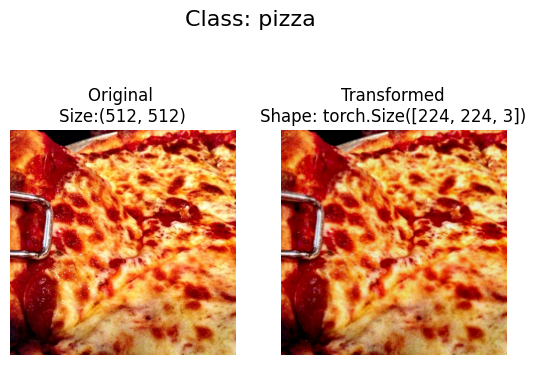

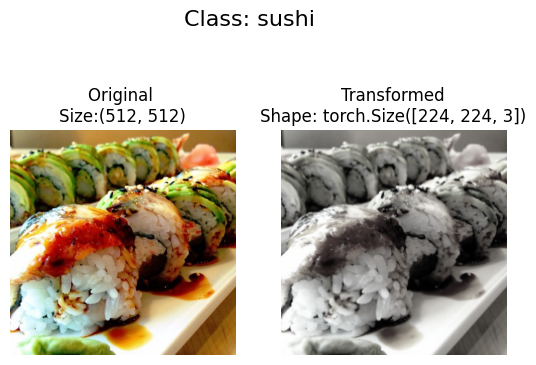

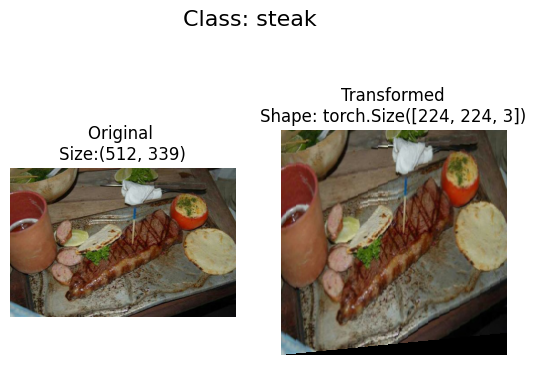

In [ ]:
plot_transformed_images(
    image_paths=image_path_list,
    transform = train_transforms,
    n=3,
    seed=None
)

In [ ]:
simple_transform = transforms.Compose([
                                      transforms.Resize(size=(64,64)),
                                      transforms.ToTensor()
])

from torchvision import datasets

train_data_simple = datasets.ImageFolder(root = train_dir,
                                         transform = simple_transform)
test_data_simple = datasets.ImageFolder(root= test_dir,
                                        transform = simple_transform)

import os
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_simple = DataLoader(dataset =train_data_simple,
                                     batch_size= BATCH_SIZE,
                                     shuffle = True,
                                     num_workers=NUM_WORKERS
                                     )

test_dataloader_simple = DataLoader(dataset =test_data_simple,
                                     batch_size= BATCH_SIZE,
                                     shuffle = False,
                                     num_workers=NUM_WORKERS
                                     )



In [ ]:


class TinyVGG(nn.Module):

  def __init__(self,
               input_shape:int,
               hidden_units:int,
               output_shape:int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size = 3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size = 3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(
            kernel_size=2,
            stride=2
        )
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size = 3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size = 3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(
            kernel_size=2,
            stride=2
        )
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13,
                  out_features=output_shape)
    )

  def forward(self,x):
    x=self.conv_block_1(x)
    #print(x.shape)
    x=self.conv_block_2(x)
    #print(x.shape)
    x=self.classifier(x)
    #print(x.shape)
    return x

In [ ]:
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names_found)).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [ ]:
image_batch, label_batch = next(iter(train_dataloader_simple))
model_0(image_batch.to(device))

tensor([[-0.0270,  0.0696, -0.0094],
        [-0.0306,  0.0607, -0.0089],
        [-0.0341,  0.0682, -0.0148],
        [-0.0341,  0.0751, -0.0121],
        [-0.0299,  0.0729, -0.0131],
        [-0.0250,  0.0793, -0.0196],
        [-0.0330,  0.0683, -0.0097],
        [-0.0301,  0.0655, -0.0116],
        [-0.0348,  0.0597, -0.0105],
        [-0.0350,  0.0642, -0.0049],
        [-0.0339,  0.0745, -0.0074],
        [-0.0379,  0.0654, -0.0090],
        [-0.0324,  0.0628, -0.0067],
        [-0.0359,  0.0685, -0.0066],
        [-0.0288,  0.0657, -0.0062],
        [-0.0339,  0.0716, -0.0164],
        [-0.0352,  0.0675, -0.0184],
        [-0.0331,  0.0649, -0.0076],
        [-0.0399,  0.0663, -0.0115],
        [-0.0330,  0.0576, -0.0093],
        [-0.0349,  0.0662, -0.0109],
        [-0.0314,  0.0653, -0.0107],
        [-0.0341,  0.0719, -0.0092],
        [-0.0347,  0.0654, -0.0103],
        [-0.0291,  0.0716, -0.0103],
        [-0.0331,  0.0681, -0.0082],
        [-0.0300,  0.0658, -0.0059],
 

In [ ]:
try:
  import torchinfo
except :
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):
  model.train()
  train_loss,train_acc=0,0

  for batch,(X,y) in enumerate (dataloader):
    X,y = X.to(device), y.to(device)

    y_pred = model(X)
    loss=loss_fn(y_pred,y)
    train_loss +=loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    y_pred_class =torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
    train_acc+=(y_pred_class==y).sum().item()/len(y_pred)

  train_loss=train_loss/len(dataloader)
  train_acc= train_acc/len(dataloader)
  return train_loss,train_acc


In [ ]:
def test_step(model: torch.nn.Module,
              dataloader:torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
  model.eval()
  test_loss,test_acc=0,0

  with torch.inference_mode():
    for batch,(X,y) in enumerate(dataloader):
      X,y = X.to(device),y.to(device)
      test_pred_logits=model(X)

      loss=loss_fn(test_pred_logits,y)
      test_loss+=loss.item()

      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc +=((test_pred_labels==y).sum().item()/len(test_pred_labels))
  test_loss=test_loss/len(dataloader)
  test_acc=test_acc/len(dataloader)
  return test_loss, test_acc


In [ ]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader,
          test_dataloader,
          optimizer,
          loss_fn:torch.nn.Module = nn.CrossEntropyLoss(),
          epochs:int=5,
          device=device):
  results ={"train_loss":[],
            "train_acc":[],
            "test_loss":[],
            "test_acc":[]}

  for epoch in tqdm(range(epochs)):
    train_loss,train_acc= train_step(model=model,
                                     dataloader=train_dataloader,
                                     loss_fn=loss_fn,
                                     optimizer=optimizer,
                                     device=device
                                     )
    test_loss,test_acc=test_step(model=model,
                                 dataloader=test_dataloader,
                                 loss_fn=loss_fn,
                                 device=device)

    print(f"Epochs:{epoch} | Train loss: {train_loss: 4f} | Train acc: {train_acc:4f} | Test Loss: {test_loss:4f} | Test acc: {test_acc: 4f}")

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
  return results

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 6
model_0 = TinyVGG(input_shape = 3, hidden_units =10,
                  output_shape=len(train_data.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

from timeit import default_timer as timer
start_time=timer()

model_0_results = train(model=model_0,
                        train_dataloader = train_dataloader_simple,
                        test_dataloader = test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn= loss_fn,
                        epochs = NUM_EPOCHS)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/6 [00:00<?, ?it/s]

Epochs:0 | Train loss:  1.106343 | Train acc: 0.304688 | Test Loss: 1.098319 | Test acc:  0.290720
Epochs:1 | Train loss:  1.099459 | Train acc: 0.332031 | Test Loss: 1.069925 | Test acc:  0.541667
Epochs:2 | Train loss:  1.086286 | Train acc: 0.492188 | Test Loss: 1.080017 | Test acc:  0.522727
Epochs:3 | Train loss:  1.082475 | Train acc: 0.410156 | Test Loss: 1.059941 | Test acc:  0.572917
Epochs:4 | Train loss:  1.062893 | Train acc: 0.414062 | Test Loss: 1.060631 | Test acc:  0.553977
Epochs:5 | Train loss:  1.020889 | Train acc: 0.460938 | Test Loss: 1.006180 | Test acc:  0.482008
Total training time: 10.839 seconds


In [ ]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

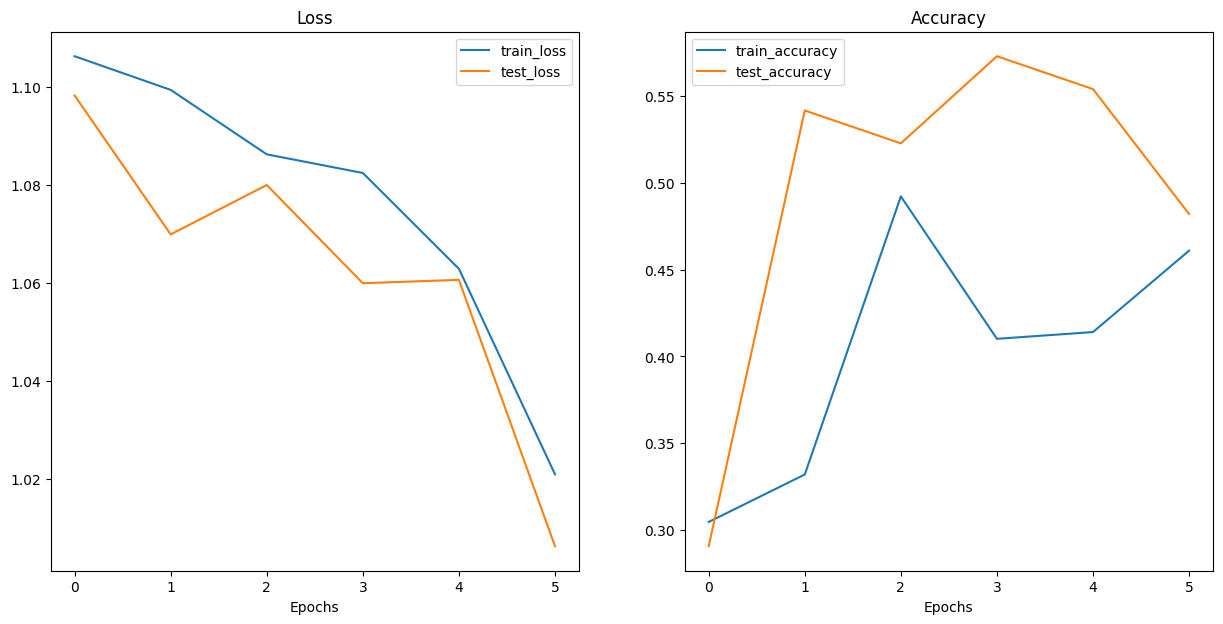

In [ ]:
plot_loss_curves(model_0_results)